In [47]:
# cd /content/drive/MyDrive/Fun With MNIST/MNIST-3(Localization)

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Input, Lambda, Flatten
from tensorflow.image import draw_bounding_boxes
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging  
import os

In [49]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   # Authenticates the Colab machine and also the TPU using your
#   # credentials so that they can access your private GCS buckets.
#   auth.authenticate_user()

In [50]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
# # print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
# print("Number of accelerators: ", strategy.num_replicas_in_sync)

In [51]:
# batch_size = 64
# BATCH_SIZE = batch_size * strategy.num_replicas_in_sync # Gobal batch size.
# # The global batch size will be automatically sharded across all
# # replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# # The best practice is to scale the batch size by the number of
# # replicas (cores). The learning rate should be increased as well.

In [3]:
BATCH_SIZE = 128

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

0


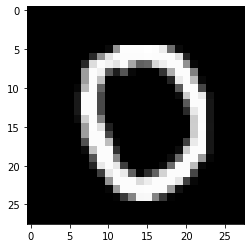

In [54]:
def display_random_digit():
    random = np.random.randint(len(X_train))
    random_image = X_train[random]
    plt.imshow(random_image, cmap = 'gray')
    print(y_train[random])

display_random_digit()

In [8]:
def print_shape():
    print('Shape of the training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nShape of the test dataset:')
    print(X_test.shape, y_test.shape)

print_shape()

Shape of the training dataset:
(60000, 28, 28, 1) (60000,)

Shape of the test dataset:
(10000, 28, 28, 1) (10000,)


In [9]:
X_train = tf.expand_dims(X_train, -1)
X_test = tf.expand_dims(X_test, -1)
print_shape()

Shape of the training dataset:
(60000, 28, 28, 1, 1) (60000,)

Shape of the test dataset:
(10000, 28, 28, 1, 1) (10000,)


In [6]:
train_datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range = 0.2, zoom_range = 0.2, rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_gen = train_datagen.flow(X_train, y_train, batch_size=1, seed = 42)
valid_gen = test_datagen.flow(X_test, y_test, batch_size=1, shuffle = False, seed = 42)

In [72]:
def preprocess_dataset(image, label):
    '''
    This function randomly places 28*28 image in 75*75 canvas and also saves the bounding box co-ordinates.
    '''
    w, h = image.shape[0], image.shape[1]

    canvas = np.zeros((75, 75), dtype = float)
    rand_width, rand_height = np.random.randint(48, size=2) # 75-28 = 47
    div = 75.0 # to normalize the values
    box = [rand_width/div, rand_height/div, (rand_width+28)/div, (rand_height+28)/div] # width is like row 
                                                                                        # and height is like column for the matrix.
    canvas[rand_width:rand_width+28, rand_height:rand_height+28] = image
    canvas = tf.expand_dims(canvas, axis = -1)
    box = np.array(box, dtype = float)
    label = tf.one_hot(label, 10)
    label = np.reshape(label, (10, ))

    return canvas, (label, box)

def display_bound_boxes(images, boxes, labels):
    '''
    Displays images with bounding boxes.
    '''
    images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images)).numpy()
    boxes = np.expand_dims(boxes, axis = 1)
    color = np.array([[1.0, 0.0, 0.0], [2.0, 0.0, 0.0]])

    images = draw_bounding_boxes(images, boxes, colors=color)

    nrows = np.ceil(len(images)/10).astype(int)
    fig, axes = plt.subplots(nrows, 10, figsize = (20, 3*nrows), sharex = True, sharey=True)
    for ax, image, label in zip(axes.ravel(), images, labels):
        # image = tf.cast(image*255, tf.uint8) # to remove the warnings but the colour of image changes

        logger = logging.getLogger()
        old_level = logger.level
        logger.setLevel(100)

        ax.imshow(image, cmap = 'gray')
        ax.set_title(np.argmax(label))

        logger.setLevel(old_level)

In [52]:
def generator(x):
    n = 0

    if x == 0: # training generator
        while(n < train_gen.__len__()):
            image, label = train_gen.next()
            image = np.reshape(image, (28, 28))
            image, y = preprocess_dataset(image, label)
            yield image, y
            n +=1

    if x == 1: # valid generator
        while(n < valid_gen.__len__()):
            image, label = valid_gen.next()
            image = np.reshape(image, (28, 28))
            image, y = preprocess_dataset(image, label)
            yield image, y
            n +=1

In [53]:
output_shapes = ([75, 75, 1], ([10,], [4,]))

train_dataset = tf.data.Dataset.from_generator(generator, args= (0,), output_types=(tf.float32, (tf.float32, tf.float32)), 
                                               output_shapes=output_shapes)
valid_dataset = tf.data.Dataset.from_generator(generator, args= (1,), output_types=(tf.float32, (tf.float32, tf.float32)), 
                                               output_shapes=output_shapes)

train_dataset = train_dataset.shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder = True).prefetch(-1)
valid_dataset = valid_dataset.shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder = True).prefetch(-1)

In [54]:
print(train_dataset)

<BatchDataset shapes: ((None, 75, 75, 1), ((None, 10), (None, 4))), types: (tf.float32, (tf.float32, tf.float32))>


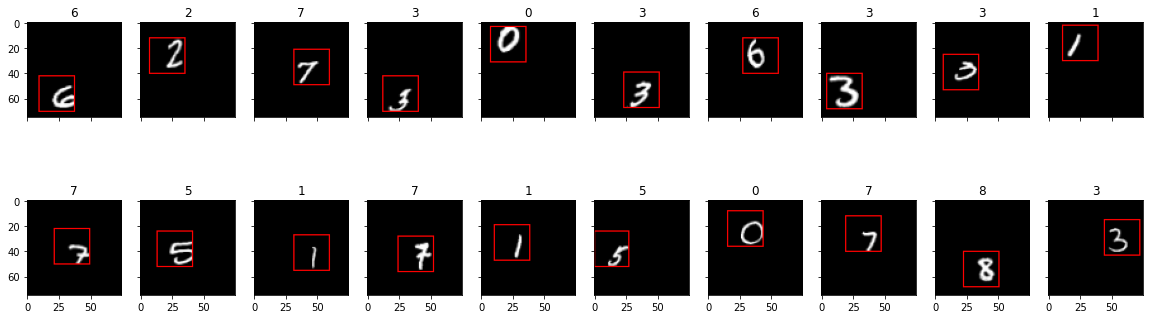

In [73]:
# Display random digits from both training and validation dataset with predictions and boxes

dataset = train_dataset
batches = 10
batch_size = 2
y = []
test_images = []
test_boxes = []
test_labels = []
for n, ex in enumerate(dataset.unbatch().batch(batch_size).shuffle(5).as_numpy_iterator()):
    if n>=batches:
        break
    y.append(ex[1])
    test_images.append(ex[0])
test_images = np.array(test_images).reshape((batches*batch_size, 75, 75, 1))

for batch in range(batches):
    test_boxes.append(y[batch][1])
    test_labels.append(y[batch][0])
test_boxes = np.array(test_boxes).reshape(batches*batch_size, 4)
test_labels = np.array(test_labels).reshape(batches*batch_size, 10)

display_bound_boxes(test_images, test_boxes, test_labels)

In [84]:
# define model

def feature_extractor(inputs):
    x = Conv2D(32, 3, padding = 'same', activation='relu')(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(32, 3, activation='relu', padding = 'same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    # x = Conv2D(64, 3, activation='relu', padding='same')(x)
    # x = MaxPooling2D()(x)

    return x

def dense_part(inputs):
    x = Flatten()(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    return x

def classifier_output(inputs):
    output = Dense(10, activation='softmax', name = 'Classifier')(inputs)

    return output

def regressor_output(inputs):
    x = Dense(32, activation = 'relu')(inputs)
    # x = Dense(10, activation = 'relu')(x)
    output = Dense(4, activation = 'relu', name = 'Regressor')(x)

    return output

# @tf.function
def myModel():
    input = Input(shape = (75, 75, 1))

    extractor_ouptput = feature_extractor(input)
    dense_output = dense_part(extractor_ouptput)
    output1 = classifier_output(dense_output)
    output2 = regressor_output(dense_output)

    model = Model(input, [output1, output2])

    return model


In [86]:
# with strategy.scope():
model = myModel()
model.compile(optimizer='adam', 
            loss = {'Classifier' : 'categorical_crossentropy',
                    'Regressor' : 'mse'
                    },
            metrics = ['accuracy'])
            #   metrics = {'Classifier' : 'accuracy',
            #              'Regressor' : 'mse'
            #             })

In [ ]:
plot_model(model, show_shapes=True)

In [21]:
def print_evaluate():
    train_c_acc = hist.history['Classifier_accuracy']
    train_r_acc = hist.history['Regressor_accuracy']
    train_loss = hist.history['loss']

    valid_c_acc = hist.history['val_Classifier_accuracy']
    valid_r_acc = hist.history['val_Regressor_accuracy']
    valid_loss = hist.history['val_loss']
    epochs = range(len(train_c_acc))

    plt.plot(epochs, train_c_acc, 'r', label = 'Train Classifier Accuracy',)
    plt.plot(epochs, valid_c_acc, 'b', label = 'Validation Classifier Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Classifier Accuracy')
    plt.show()

    plt.plot(epochs, train_r_acc, 'r', label = 'Train Regressor Accuracy',)
    plt.plot(epochs, valid_r_acc, 'b', label = 'Validation Regressor Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Regressor Accuracy')
    plt.show()

    plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
    plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    # loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
    # print(loss)
    # print(int(accuracy * 100), '%')

In [22]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_Regressor_accuracy', min_delta = 0.01, patience=10, verbose = 1, restore_best_weights=True)

In [88]:
epochs = 50
steps_per_epoch = 60000//BATCH_SIZE
val_steps = 10000//BATCH_SIZE

hist = model.fit(train_dataset, epochs = epochs, steps_per_epoch= steps_per_epoch, validation_data= valid_dataset, validation_steps= val_steps, callbacks=[es])

Epoch 1/50
468/468 [==============================] - 157s 332ms/step - loss: 1.0556 - Classifier_loss: 1.0393 - Regressor_loss: 0.0163 - Classifier_accuracy: 0.6331 - Regressor_accuracy: 0.8106 - val_loss: 0.2643 - val_Classifier_loss: 0.2501 - val_Regressor_loss: 0.0142 - val_Classifier_accuracy: 0.9233 - val_Regressor_accuracy: 0.8726
Epoch 2/50
468/468 [==============================] - 155s 332ms/step - loss: 0.3125 - Classifier_loss: 0.3045 - Regressor_loss: 0.0080 - Classifier_accuracy: 0.9048 - Regressor_accuracy: 0.8628 - val_loss: 0.1412 - val_Classifier_loss: 0.1349 - val_Regressor_loss: 0.0063 - val_Classifier_accuracy: 0.9566 - val_Regressor_accuracy: 0.9073
Epoch 3/50
468/468 [==============================] - 157s 335ms/step - loss: 0.1927 - Classifier_loss: 0.1874 - Regressor_loss: 0.0053 - Classifier_accuracy: 0.9414 - Regressor_accuracy: 0.8892 - val_loss: 0.1239 - val_Classifier_loss: 0.1194 - val_Regressor_loss: 0.0045 - val_Classifier_accuracy: 0.9628 - val_Regress

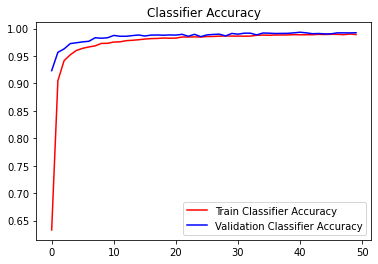

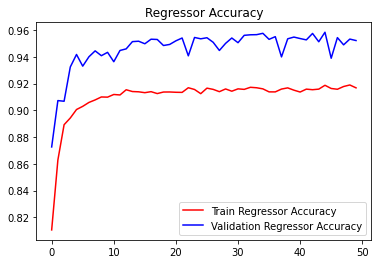

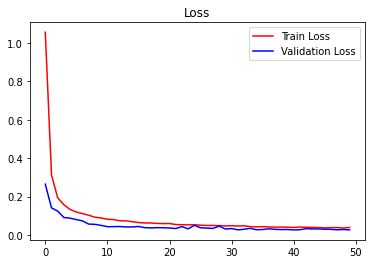

In [89]:
print_evaluate()

In [90]:
output = model.evaluate(valid_dataset, steps = val_steps)
print(len(output))


78/78 [==============================] - 18s 211ms/step - loss: 0.0246 - Classifier_loss: 0.0231 - Regressor_loss: 0.0015 - Classifier_accuracy: 0.9918 - Regressor_accuracy: 0.9537
5


In [91]:
for val in output:
    print(val)

0.024626918137073517
0.023100167512893677
0.0015267517883330584
0.9917868375778198
0.9537259340286255


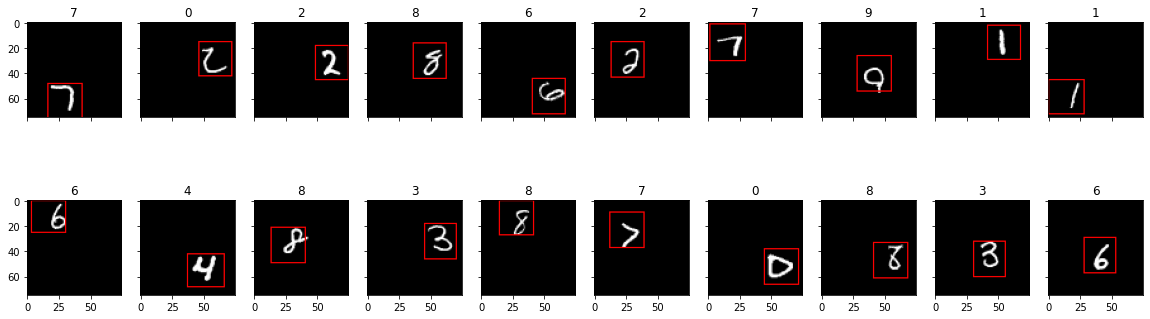

In [92]:
# Display predictions from validation dataset along with bounding boxes

batches = 2
batch_size = 10
pred = []
test_images = []
for n, ex in enumerate(valid_dataset.unbatch().batch(batch_size).shuffle(100).as_numpy_iterator()):
    if n>=batches:
        break
    pred.append(model.predict([[ex[0]]]))
    test_images.append(ex[0])
    # print(ex[1][1].shape)
test_images = np.array(test_images).reshape((batches*batch_size, 75, 75, 1))

test_boxes = []
test_labels = []
for batch in range(batches):
    test_boxes.append(pred[batch][1])
    test_labels.append(pred[batch][0])
test_boxes = np.array(test_boxes).reshape(batches*batch_size, 4)
test_labels = np.array(test_labels).reshape(batches*batch_size, 10)
# Prediction on validation dataset

display_bound_boxes(test_images, test_boxes, test_labels)

In [93]:
model.save('mnist-3-5.h5')